In [35]:
import pickle
import numpy as np
import pandas as pd
import re
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from umap import UMAP
from bertopic import BERTopic
from pathlib import Path
from typing import Dict

In [23]:
def read_pickle(file_path):
    with open(file_path, "rb") as f:
        return pickle.load(f)

def flatten_embeddings(emb_dict: Dict[str, np.ndarray]) -> np.ndarray:
    return np.vstack(emb_dict.values())
    
def get_model_name(model_path: Path) -> str:
    return re.match("\w+-\w+-\d+", model_path.name).group()

    
def get_train_filter(train_index: pd.Index) -> np.ndarray:
    return np.isin(np.arange(50000), train_index)

In [37]:
# Loading data
DATA_DIR = Path("../data")
MODEL_DIR = Path("../models")
model = next(MODEL_DIR.glob("*topic_model"))
model_name = get_model_name(model)
train_index = pd.read_csv(DATA_DIR / "imdb_train.csv").index
embeddings = np.load(DATA_DIR / "bert-base-uncased-imdb_embs.npy")
probs = np.load(DATA_DIR / f"{model_name}_probs.npy")

In [40]:
umap_model = UMAP(
    n_neighbors=30,
    min_dist=0.2,
    n_components=2,
    random_state=42,
)
umap_embeddings = umap_model.fit_transform(embeddings, None)

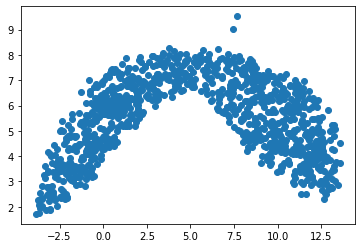

In [43]:
idxs = np.random.choice(umap_embeddings.shape[0], size=1000, replace=False)
test_embeddings = umap_embeddings[idxs, :]

plt.scatter(test_embeddings[:, 0], test_embeddings[:, 1])

In [16]:
umap_embeddings.shape

(50000, 3)

C:\Users\jhr\AppData\Local\Temp/ipykernel_22460/1161787161.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


IndexError: index 2 is out of bounds for axis 1 with size 2

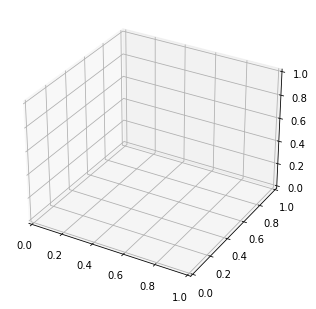

In [44]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], umap_embeddings[:, 2])
plt.show()

# Finding centroids

In [26]:

train_embs = embeddings[get_train_filter(train_index), :]

In [31]:
print(f"{probs.shape = }")
print(f"{train_embs.shape = }")


centroids = np.zeros((10, 768))

for i, col in enumerate(probs.T):
    centroids[i, :] = np.average(train_embs, axis=0, weights=col)

probs.shape = (45759, 10)
train_embs.shape = (45759, 768)


In [36]:
topic_model = BERTopic.load(model)

In [19]:
model.calculate_centroids(doc_topics["topic"], doc_topics["prob"], embeddings)

array([[-0.31369581,  0.14069182,  0.30839828, ...,  0.14768848,
        -0.31350435, -0.07608722],
       [-0.34384449,  0.11415869,  0.30685374, ...,  0.18315915,
        -0.23269803, -0.07757123],
       [-0.34133812,  0.16279837,  0.30273958, ...,  0.1487918 ,
        -0.30827798, -0.04475188],
       [-0.316619  ,  0.09571641,  0.18792396, ...,  0.2236739 ,
        -0.19927784, -0.09734898],
       [-0.52454731,  0.13400279,  0.13540939, ...,  0.43394851,
        -0.15234472, -0.14136522]])

In [34]:
# Transform and remove nan
new_features = model.transform_many(embeddings_dict.values())
new_features = new_features[~np.isnan(new_features).any(axis=1)]

In [37]:
new_features.shape

(7835, 5)

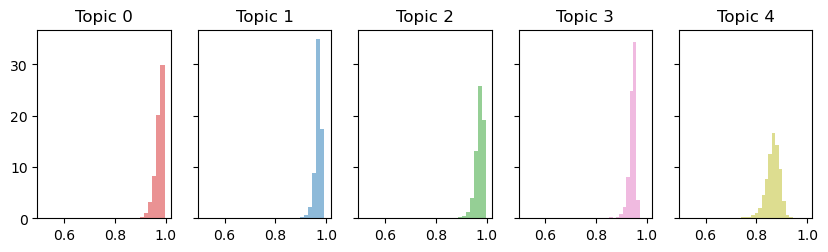

In [43]:
# Visualize this bad boi
from matplotlib import pyplot as plt 
# Plot
fig, axes = plt.subplots(1, 5, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']

for i, ax in enumerate(axes.flatten()):
    ax.hist(new_features[:, i], alpha=0.5, bins=30, density=True, stacked=True, label=i, color=colors[i])
    ax.set_title(f"Topic {i}")